In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import asPolygon, Point
import open3d as o3d
from scipy.spatial.transform import Rotation

In [2]:
M = 8 / 100  # maximum camber
P = 6 / 10  # position of maximum camber
T = 40 / 100  # thickness

In [3]:
a0 = 0.2969
a1 = -0.126
a2 = -0.3516
a3 = 0.2843
a4 = -0.1036  # for closed trailing edge

In [4]:
def yc(x):
    return np.where(x < P, (M/P**2) * (2*P*x - x**2), (M / (1-P)**2) * (1 - 2*P + 2*P*x - x**2))

def yc_grad(x):
    return np.where(x < P, (2*M/P**2) * (P-x), (2*M / (1-P)**2) * (P-x))

def yt(x):
    return (T/0.2) * (a0*x**0.5 + a1*x + a2*x**2 + a3*x**3 + a4*x**4)

def theta(yc_grad):
    return np.arctan(yc_grad)

def x_u(x):
    return x - yt(x) * np.sin(theta(yc_grad(x)))

def x_l(x):
    return x + yt(x) * np.sin(theta(yc_grad(x)))

def y_u(x):
    return yc(x) + yt(x) * np.cos(theta(yc_grad(x)))

def y_l(x):
    return yc(x) - yt(x) * np.cos(theta(yc_grad(x)))

def x_c(beta):
    return (1 - np.cos(beta)) / 2

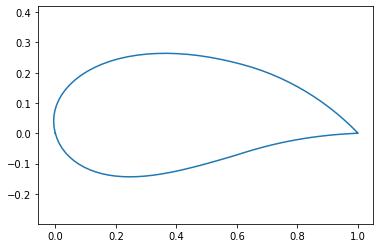

In [5]:
NUM_POINTS = 100

def naca_airfoil():
    airfoil = np.zeros((NUM_POINTS, 2))

    beta = np.linspace(0, np.pi, num=(NUM_POINTS//2))

    airfoil[:(NUM_POINTS//2), 0] = np.reshape(x_u(x_c(beta)), -1)
    airfoil[:(NUM_POINTS//2), 1] = np.reshape(y_u(x_c(beta)), -1)

    airfoil[(NUM_POINTS//2):, 0] = np.reshape(x_l(x_c(beta)), -1)[::-1]  # reverse lower surface points for polygon
    airfoil[(NUM_POINTS//2):, 1] = np.reshape(y_l(x_c(beta)), -1)[::-1]

    return airfoil

airfoil = naca_airfoil()
plt.axis('equal')
plt.plot(airfoil[:,0], airfoil[:,1])

In [6]:
# in mm

NUM_POINTS = 10000
SIGMA = 1
HEIGHT = 100
SCALE = 100

NUM_POINTS_IN_FLOOR = 10000
FLOOR_SIGMA = 1
FLOOR_SIZE = 200


In [7]:
rng = np.random.default_rng()

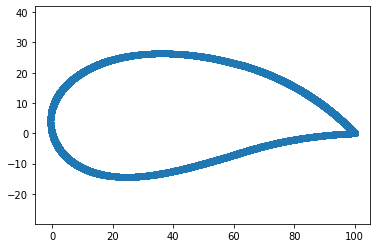

In [8]:
def sample_airfoil():
    beta_upper = rng.random(NUM_POINTS // 2) * np.pi
    beta_lower = rng.random(NUM_POINTS // 2) * np.pi

    sampled_airfoil = np.zeros((NUM_POINTS, 2))

    sampled_airfoil[:len(beta_upper), 0] = np.reshape(x_u(x_c(beta_upper)), -1) * SCALE
    sampled_airfoil[:len(beta_upper), 1] = np.reshape(y_u(x_c(beta_upper)), -1) * SCALE

    sampled_airfoil[len(beta_lower):, 0] = np.reshape(x_l(x_c(beta_lower)), -1) * SCALE
    sampled_airfoil[len(beta_lower):, 1] = np.reshape(y_l(x_c(beta_lower)), -1) * SCALE
    
    return sampled_airfoil

sampled_airfoil = sample_airfoil()

plt.axis('equal')
plt.scatter(sampled_airfoil[:, 0], sampled_airfoil[:, 1])

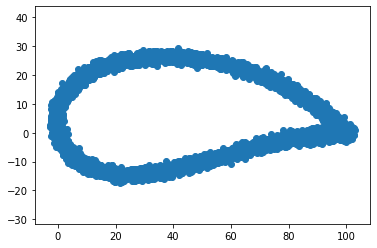

In [9]:
def sample_airfoil_w_noise():
    sampled_airfoil = sample_airfoil()
    return sampled_airfoil + rng.normal(0, SIGMA, size=(sampled_airfoil.shape[0], 2))

sampled_airfoil_w_noise = sample_airfoil_w_noise()

plt.axis('equal')
plt.scatter(sampled_airfoil_w_noise[:, 0], sampled_airfoil_w_noise[:, 1])

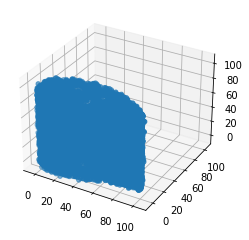

In [10]:
def sample_airfoil_3d():
    sampled_airfoil_w_noise = sample_airfoil_w_noise()
    z = rng.uniform(0, HEIGHT, sampled_airfoil_w_noise.shape[0])
    return np.append(sampled_airfoil_w_noise, np.reshape(z, (-1, 1)), axis=1)

sampled_airfoil_3d = sample_airfoil_3d()

axes_range = (-10, 110)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', xlim=axes_range, ylim=axes_range, zlim=axes_range)
ax.scatter(sampled_airfoil_3d[:, 0], sampled_airfoil_3d[:, 1], sampled_airfoil_3d[:, 2])

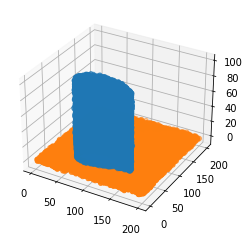

In [11]:
AIRFOIL_TRANSLATION = (FLOOR_SIZE - SCALE) // 2

def is_point_in_airfoil(point):
    polygon = asPolygon(naca_airfoil() * SCALE + AIRFOIL_TRANSLATION)
    return polygon.contains(Point(point[0], point[1]))

def sample_floor():
    floor = np.zeros((NUM_POINTS_IN_FLOOR, 3))
    floor[:,:2] = rng.uniform(0, FLOOR_SIZE, size=(NUM_POINTS_IN_FLOOR, 2))
    floor[:,2] = rng.normal(0, FLOOR_SIGMA, size=NUM_POINTS_IN_FLOOR)

    # do not put points under the airfoil
    outside_airfoil = [not is_point_in_airfoil(point) for point in floor]
    return floor[outside_airfoil]

sampled_airfoil_3d = sample_airfoil_3d()
sampled_airfoil_3d[:,:2] += AIRFOIL_TRANSLATION

sampled_floor = sample_floor()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sampled_airfoil_3d[:, 0], sampled_airfoil_3d[:, 1], sampled_airfoil_3d[:, 2])
ax.scatter(sampled_floor[:, 0], sampled_floor[:, 1], sampled_floor[:, 2])

In [12]:
def sample_wall():
    # generate wall on y-z plane
    wall = np.zeros((NUM_POINTS_IN_FLOOR, 3))
    wall[:,1:] = rng.uniform(0, FLOOR_SIZE, size=(NUM_POINTS_IN_FLOOR, 2))
    wall[:,0] = rng.normal(0, FLOOR_SIGMA, size=NUM_POINTS_IN_FLOOR)
    return wall

In [13]:
def get_o3d_axes(size=50):
    return o3d.geometry.TriangleMesh.create_coordinate_frame(size=size)

In [14]:
# generate pointcloud
sampled_airfoil_3d = sample_airfoil_3d()
sampled_airfoil_3d[:,:2] += AIRFOIL_TRANSLATION

sampled_floor = sample_floor()
sampled_wall = sample_wall()

points = np.concatenate((sampled_airfoil_3d, sampled_floor, sampled_wall))

In [30]:
# convert to open3d objects

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)

axes = get_o3d_axes(size=50)

In [16]:
# random rotation in x,y by max 40degs. random rotation in z
# random translation in x,y,z

max_rot = np.radians(40)

r = Rotation.from_rotvec([rng.uniform(-max_rot, max_rot), rng.uniform(-max_rot, max_rot), rng.uniform(0, 2*np.pi)])

pcd.rotate(r.as_matrix(), [0,0,0])
pcd.translate(rng.uniform(-50, 50, size=3))

o3d.visualization.draw_geometries([pcd, axes])

In [17]:
# estimate normal directions for each point

pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

o3d.visualization.draw_geometries([pcd, axes], point_show_normal=True)

In [18]:
# find 2 planes with largest supports in the point cloud
# these are the floor and the wall

plane1, inliers1 = pcd.segment_plane(distance_threshold=1, ransac_n=3, num_iterations=1000)

outlier1_cloud = pcd.select_by_index(inliers1, invert=True)

plane2, inliers2 = outlier1_cloud.segment_plane(distance_threshold=1, ransac_n=3, num_iterations=1000)

[a1, b1, c1, d1] = plane1
print(f"Plane 1 equation: {a1:.3f}x + {b1:.3f}y + {c1:.3f}z + {d1:.3f} = 0")

[a2, b2, c2, d2] = plane2
print(f"Plane 2 equation: {a2:.3f}x + {b2:.3f}y + {c2:.3f}z + {d2:.3f} = 0")

plane1_cloud = pcd.select_by_index(inliers1)
plane1_cloud.paint_uniform_color([1.0, 0, 0])

plane2_cloud = outlier1_cloud.select_by_index(inliers2)
plane2_cloud.paint_uniform_color([0, 1.0, 0])

remaining_cloud = outlier1_cloud.select_by_index(inliers2, invert=True)

o3d.visualization.draw_geometries([plane1_cloud, plane2_cloud, remaining_cloud, axes])

Plane 1 equation: 0.531x + 0.846y + 0.044z + -1.340 = 0
Plane 2 equation: 0.239x + -0.200y + 0.950z + -24.138 = 0


In [19]:
# identify which plane is the floor and which is the wall

if c1 > c2:
    floor, wall = plane1, plane2
else:
    floor, wall = plane2, plane1

In [20]:
# rotate point cloud and translate so floor is on xy plane and wall is on yz plane

# find rotation matrix
align_mat, _ = Rotation.align_vectors([[0,0,1], [1,0,0]], [floor[:3], wall[:3]])

pcd.rotate(align_mat.as_matrix(), [0,0,0])
pcd.translate([wall[3], 0, floor[3]])

o3d.visualization.draw_geometries([pcd, axes])

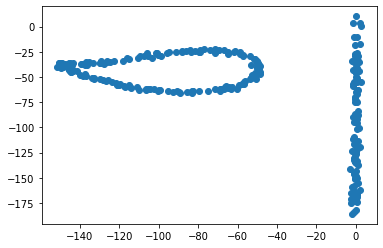

In [28]:
# take a cut

h = 50

points = np.asarray(pcd.points)
cut = points[(points[:,2] < h+1) & (points[:,2] > h-1)]

plt.scatter(cut[:,0], cut[:,1])

In [35]:
# Poisson surface reconstruction

pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(100)

with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd)

print(mesh)
o3d.visualization.draw_geometries([mesh])

AttributeError: 'open3d.open3d_pybind.geometry.PointCloud' object has no attribute 'orient_normals_consistent_tangent_plane'

In [21]:
o3d.visualization.draw_geometries([pcd, axes])